# COVID-19
*A simple tool to analyse pandemic diffusion in every country (and a Python tutorial)*

This work is copyright (c) 2020 of Giovanni Organtini (giovanni.organtini@uniroma1.it)
It is distributed under the GPL as stated below, following GNU's prescriptions

<pre>
    covid19.py - Analyse data of the spread of the COVID19
    Copyright (C) 2020 giovanni.organtini@uniroma1.it

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
</pre>
Such a license allows you to use this software, copy, modify and redistribute it, if you want (and, of course, if you can). Software distributed like this is called _Open Source_. We encourage you to use Open Source software, learn how to write it and distribute your own work with one of the many open licenses. You can find other open software from the same author on [github.com/organtin](https://github.com/organtin)

In [21]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import ssl

The above lines _import_ external libraries or packages (aka modules). Libraries consist of software dedicated to simplify the development of other software. In order to import a module the keyword `import` is used followed by the name of the library. One can create an _alias_ for the module using the keyword `as` as, e.g.,

`import numpy as np`

imports a library called `numpy` and create an alias to it as `np`, such that in the following we can refer to `numpy` as `np`. 

Modules may be composed by submodules. We may be interested in using just few submodules of a module. In that case we can load only the interesting parts into the memory. Submodule names are separated by a dot from their container module. For example, submodule `pyplot`, included in `matplotlib` is loaded as aliased to `plt`.

From a module or a submodule we can even load just a single function, such as in

`from scipy.signal import savgol_filter`

where we just load function `savgol_filter` included in the `signal` submodule of `scipy`.

In [23]:
ssl._create_default_https_context = ssl._create_unverified_context

The above line is needed to overcome a difficulty arising when downloading data from a secure server. If the client is unable to verify the server certificate for any reason, the download will fail. The above line allows the client to download data even if the identity of the server cannot be verified. This, of course, is a security issue that in this case is mitigated by the fact that the servers identity has been verified by hand.

In [ ]:
urlc = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

# download data
w = pd.read_csv(wget.download(urlc), header = [0])
w = w.groupby('Country/Region', as_index=False).sum()

# get population (data avilable till 2018)
urlp = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv'
wp = pd.read_csv(wget.download(urlp), header = [0])

The above line actually download data. Data are available in the form of a CSV file from the URL defined as `urlc`. The file is downloaded with `wget.download()` whose unique paramater is the URL. Once downloaded the file is used as an argument for `read_csv()` (a method of the `pandas` library), whose name is self_explanatory.

`w` contains actual data in a tabular form called dataframe. The first columns contains the State name, while the second one the Country. They may differ in different cases. For example, Alabama and California are two states of the US Country. We want to sum up all the data belonging to the same Country. To do that, we group the data by the second column, whose header is `'Country/Region'`. The optional argument `as_index=False` makes the index used in `group_by` to become the index of the resulting dataframe. By default, the index is an integer number starting from 0. Grouped data are then summed together using `sum()`.

In [ ]:
# select data
# countries = ['Italy', 'Germany', 'United Kingdom', 'Spain']
countries = ['US']

Here we choose the countries to analyse. `countries` is a list. Each element is the name of a country as given in the data file. It must be enclosed in quotes. Lines starting with a pound (`#`) are comments, i.e., they are ignored.

In [25]:
population = {}
for country in countries:
    # manage differences in naming
    if country == 'US':
        country = 'United States'
    df = wp.loc[(wp['Country Name'] == country) & (wp['Year'] == 2018)]
    population[country] = df.iloc[0]['Value']
    print(f'{country}: ' + str(population[country]))
    if country == 'United States':
        population['US'] = population[country]

United States: 326687501


In the above lines we compute the population of the countries to which we are interested. We create an empty _dictionary_ called `population` and select the lines in the dataframe according to the condition given in the square brackets passed as an argument to `loc`. The population file has several rows per country: one per year. We extract those that match the wanted countries for the latest available year. The corresponding column `'Value'` is used as the value to be associated to a key built out from the counrty name. There can be differences between the naming of countries in the two CSV files used: we adjust them manually.

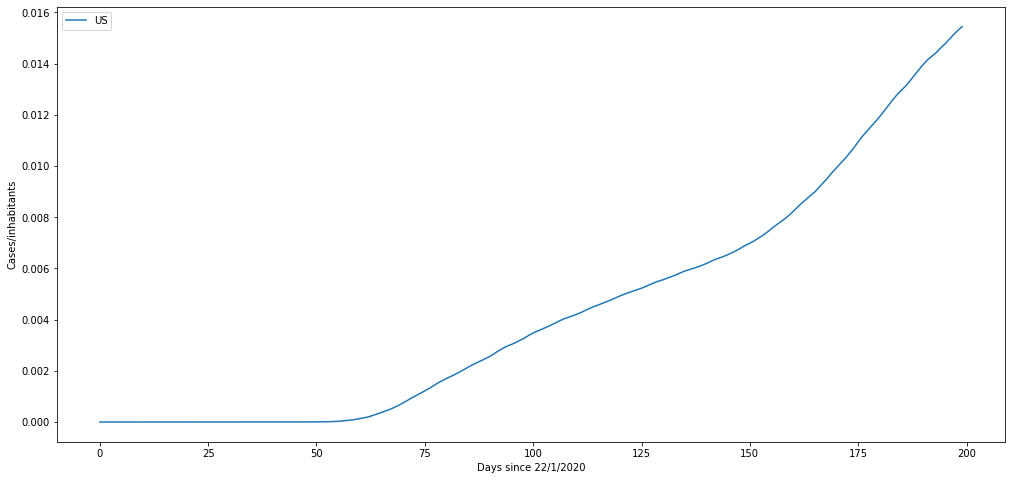

In [26]:
plt.figure(figsize=(17,8))

# count cases
for country in countries:
    select_country = w.loc[w['Country/Region'] == country]
    cases = select_country.values.tolist()[0][4:]/population[country]
    plt.plot(cases, label = country)

# plot
plt.xlabel('Days since 22/1/2020')
plt.ylabel('Cases/inhabitants')
plt.legend()
plt.savefig('cases.png')
plt.show()

Here we make the first plot. As above, we select the rows of the dataframe containing cases matching the country name. We extract the values from the dataframe (i.e. we drop the index) and discard the first four columns (the first two contains, as said, state and country names; the third is the latitude and the fourth the longitude. All the other columns contain the number of cases reported per day. The result is converted into a plain list (`select_country.values` looks like a list, but in fact is a bit more complicated).

Each element in the list is then divided by the population of the given country. 

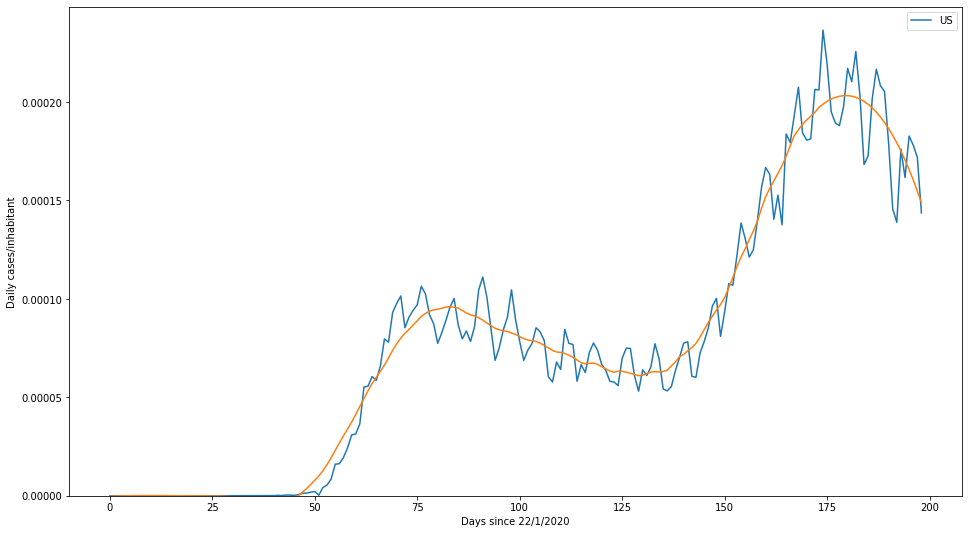

In [31]:
plt.figure(figsize=(16,9))

# make a plot of derivatives
for country in countries:
    select_country = w.loc[w['Country/Region'] == country]
    cases = select_country.values.tolist()[0][4:]/population[country]
    diff = []
    for x, y in zip(cases[0::], cases[1::]):
        diff.append(y - x)
    plt.plot(diff, label = country)
    # smooth t
    yhat = savgol_filter(diff, 51, 3)
    plt.plot(yhat)
    
# plot
plt.xlabel('Days since 22/1/2020')
plt.ylabel('Daily cases/inhabitant')
plt.legend()
plt.ylim(0)
plt.savefig('dailycases.png')
plt.show()

The second plot contains data about the daily cases computed taking the difference between adjacente elements in the list. For each country we create an empty list `diff`, to which we append the differences computed looping on the list elements. The loop is done using _list comprehension_. `zip(a, b)` _glues_ two lists `a` and `b`: imagine the result as a two rows table with N columns. The `for` in the parenthesis navigate on all columns of the table returning iteratively `x` and `y` as the currently visited elements in `a` and `b`, respectively. In the above example list `a` is `cases[0::]` representing the list `cases` starting from element `0`. `cases[1::]` represents the same list starting from element `1`. So, if `cases` contains, e.g., [23, 43, 12, 3, 56, ...], `cases[0::]` coincides with `cases` (we make indexes explicit for readibility purposes), while `cases[1::]` contains [43, 12, 3, 56, ...] such that the first (x, y) pair returned by the `for` loop is (23, 43) and `y-x` is 43-23=20.

We plot the resulting list labelling it with the country name.

Then we smooth the data using a statistical filter (`savgol_filter`) to get rid of too many fluctuations, then add labels to the x- and y-axis. With `legend()` we ask Python to write a legend based on the labels given to data sets, avoid plotting negative data and save the figure in a png file before showing it.